# Setting things up

In [1]:
from general import *
from exp1 import *
import time
import pandas as pd
import multiprocessing as mp

random_state=42
np.random.seed(random_state)
cpu=mp.cpu_count() 
cpu

8

In [2]:
####
alpha=.1 #Significance level
iterations=48  #MC simulations to calculate type-1 error and power
ps=[30] #Z dim
skew=0
m=800 #Training set size
n=200 #Test set size
B=100 #Number of permutations/samplings (RESIT,CRT,CPT)
npar = 7 #Number of different values for parameters like gamma, theta, c etc.
nbas = 10 #Number of different generative configurations (different pairs (a,b))

####
skews = [0]
losses = ['mse']

# Experiments

In [3]:
results = {'set':[], 'p':[],
           'ba':[], 'c':[], 'theta':[], 'skew':[], 'gamma':[], 'loss':[],
           'stfr':[], 'resit':[], 'gcm':[], 'crt':[], 'cpt':[],'rbpt':[], 'rbpt2':[],
           'stfr_time':[], 'resit_time':[], 'gcm_time':[], 'crt_time':[], 'cpt_time':[], 'rbpt_time':[], 'rbpt2_time':[]}

count=0

for p in ps:
    
    bas = [[np.random.normal(0, 1, p).reshape(p,1), np.random.normal(0, 1, p).reshape(p,1)] for j in range(nbas)]
    
    for ba in bas:
        # Parameters a and b
        b = ba[0]
        a = ba[1]
        
        thetas = [0,2,4,6]
        for theta in tqdm(thetas):
            for loss in losses:

                #### Type I error ####
                c = 0

                #STFR,RESIT,GCM,RBPT,RBPT2#
                tests={'stfr':False, 'resit':False, 'gcm':False, 'crt':True, 'cpt':True, 'rbpt':True, 'rbpt2':False}
                gammas = np.linspace(0,.02,npar)
                for gamma in gammas:
                    # Running
                    pool = mp.Pool(cpu)
                    out = pool.starmap(exp1, [(it, theta, gamma, c, a, b, skew, m, n, p, loss, alpha, B, tests) for it in range(iterations)])
                    pool.close()
                    pool.join()
                    out = np.array(out).mean(axis=0)

                    # Storing results
                    results['set'].append('type1_1'); results['p'].append(p)
                    results['ba'].append(count); results['c'].append(c); results['theta'].append(theta); results['skew'].append(skew); results['gamma'].append(gamma); results['loss'].append(loss) 
                    results['stfr'].append(out[0]); results['resit'].append(out[1]); results['gcm'].append(out[2]); results['crt'].append(out[3]); results['cpt'].append(out[4]); results['rbpt'].append(out[5]); results['rbpt2'].append(out[6])
                    results['stfr_time'].append(out[7]); results['resit_time'].append(out[8]); results['gcm_time'].append(out[9]); results['crt_time'].append(out[10]); results['cpt_time'].append(out[11]); results['rbpt_time'].append(out[12]); results['rbpt2_time'].append(out[13])
                
        # Update 'count'
        count+=1

100%|█████████████████████████████████████████████| 4/4 [03:17<00:00, 49.42s/it]


## Saving results

In [4]:
results = pd.DataFrame(results)
results.to_csv('results/artificial_data_experiments3.csv')

In [5]:
results = pd.read_csv('results/artificial_data_experiments3.csv')

In [6]:
results.iloc[:,16:].describe()

,stfr_time,resit_time,gcm_time,crt_time,cpt_time,rbpt_time,rbpt2_time
count,0.0,0.0,0.0,280.000000,280.000000,280.000000,0.0
mean,NaN,NaN,NaN,0.023546,0.792180,0.000719,NaN
std,NaN,NaN,NaN,0.007291,0.187856,0.000213,NaN
min,NaN,NaN,NaN,0.012133,0.446978,0.000350,NaN
25%,NaN,NaN,NaN,0.018727,0.626663,0.000557,NaN
50%,NaN,NaN,NaN,0.023722,0.793435,0.000730,NaN
75%,NaN,NaN,NaN,0.027603,0.930755,0.000840,NaN
max,NaN,NaN,NaN,0.097350,1.541942,0.001814,NaN


In [7]:
columns_by = ['set','c','theta','skew','gamma','loss']
results_mean = results.groupby(by=columns_by).mean().reset_index()
results_std = results.groupby(by=columns_by).std().reset_index()

colors = ['#1f77b4', '#8c564b', '#e377c2']
names=['RBPT', 'CRT', 'CPT']

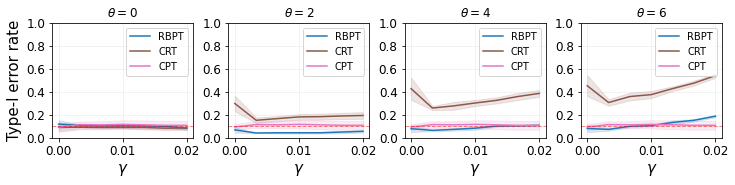

In [13]:
plt.figure(figsize=(12,2))
plt.subplots_adjust(left, bottom, right, top, .25, hspace)

for i in range(len(thetas)):
    plt.subplot(1, len(thetas), i+1)
    theta = thetas[i]
    
    j, x, y, z = 0, gammas, results_mean.loc[results_mean.theta==theta].rbpt, results_std.loc[results_std.theta==theta].rbpt
    plt.plot(x, y, label=names[j], color=colors[j])
    plt.fill_between(x, y-z, y+z, color=colors[j], alpha=.15)

    j, x, y, z = 1, gammas, results_mean.loc[results_mean.theta==theta].crt, results_std.loc[results_std.theta==theta].crt
    plt.plot(x, y, label=names[j], color=colors[j])
    plt.fill_between(x, y-z, y+z, color=colors[j], alpha=.15)

    j, x, y, z = 2, gammas, results_mean.loc[results_mean.theta==theta].cpt, results_std.loc[results_std.theta==theta].cpt
    plt.plot(x, y, label=names[j], color=colors[j])
    plt.fill_between(x, y-z, y+z, color=colors[j], alpha=.15)

    plt.xticks(fontsize=12)
    plt.xlabel('$\gamma$', size=15)
    plt.yticks(fontsize=12)
    if i==0:
        plt.ylabel('Type-I error rate', size=15)
    else:
        plt.ylabel('', size=1)
    plt.title("$\\theta={:}$".format(theta))
    plt.grid(alpha=.2)
    plt.ylim(0,1)
    plt.axhline(y=alpha, color='r', linestyle='--', lw=1, alpha=.5)
    plt.legend()

plt.savefig('plots/exp_review1.png', bbox_inches='tight', dpi=300, transparent=True)    
plt.show()